In [1]:
import numpy as np
import pandas as pd
from surprise import Reader, Dataset
from tqdm import tqdm
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from collections import defaultdict
from math import log2
tqdm.pandas()
from surprise import NMF
from sklearn.utils import resample

In [2]:
# Load and filter data
interactions = pd.read_pickle('../Pickle/interactions.pkl')
books = pd.read_pickle('../Pickle/books.pkl')
imputed = pd.read_pickle('../Pickle/imputed_ratings.pkl')

interactions = interactions[['user_id', 'book_id', 'rating', 'is_read']]  

In [3]:
interactions = interactions[interactions['rating'] != 0]

In [6]:
frames = [interactions, imputed]

In [7]:
interactions = pd.concat(frames)

In [36]:
interactions

,user_id,book_id,rating,is_read
1,0,14,5.0,True
2,0,21,5.0,True
3,0,22,3.0,True
4,0,23,4.0,True
5,0,24,4.0,True
...,...,...,...,...
37463,1972,87775,5.0,NaN
37464,1972,17400,5.0,NaN
37465,1972,58820,5.0,NaN
37466,1972,21104,3.0,NaN


In [ ]:
import pickle
with open('../Pickle/interactions.pkl', 'wb') as f:
    pickle.dump(interactions, f)

In [10]:
def split_data_with_single_interactions(df):
    # Identify users and books that appear only once in the dataset
    user_counts = df['user_id'].value_counts()
    book_counts = df['book_id'].value_counts()

    # Find interactions where user or book appears only once
    single_interactions = df[
        df['user_id'].isin(user_counts[user_counts == 1].index) | 
        df['book_id'].isin(book_counts[book_counts == 1].index)
    ]

    # Remove those interactions from the main dataset
    remaining_interactions = df[~df.index.isin(single_interactions.index)]

    # Split the remaining interactions into train and test using sklearn's train_test_split
    train_df, test_df = train_test_split(remaining_interactions, test_size=0.2, random_state=42, stratify=remaining_interactions['rating'])

    # Add the single interactions to the training set
    train_df = pd.concat([train_df, single_interactions], ignore_index=True)


    return train_df, test_df

train_df, test_df = split_data_with_single_interactions(interactions)

In [11]:
len(train_df)

420693

In [12]:
rating_counts = train_df['rating'].value_counts()

# Find the majority class size (highest count)
majority_count = rating_counts.max()

MAX_TARGET_SIZE = int(0.6 * majority_count)

modified_dfs = []

# Perform upsampling with slight noise addition for each class
for rating, count in rating_counts.items():
    class_df = train_df[train_df['rating'] == rating]

    if count >= MAX_TARGET_SIZE:
        balanced_df = class_df.copy()
    else:
        balanced_df = resample(class_df,
                               replace=True,
                               n_samples=MAX_TARGET_SIZE,
                               random_state=42)

        # Add random noise to the ratings
        balanced_df['rating'] = balanced_df['rating'] + np.random.uniform(-0.1, 0.1, size=balanced_df.shape[0])
        # Ensure ratings are within the valid range (e.g., between 1 and 5)
        balanced_df['rating'] = balanced_df['rating'].clip(1, 5)

    modified_dfs.append(balanced_df)


balanced_train = pd.concat(modified_dfs, ignore_index=True)

# Shuffle dataset
train_df = balanced_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [13]:
len(train_df)

583203

In [14]:
# Log scale ratings
def normalise_ratings(train_data, test_data):
    min_rating = train_data['rating'].min()
    
    if min_rating < 0:
        train_data['rating'] = train_data['rating'] - min_rating
        test_data['rating'] = test_data['rating'] - min_rating

    train_data['rating'] = np.log1p(train_data['rating'])
    test_data['rating'] = np.log1p(test_data['rating'])

    return train_data, test_data, min_rating


def denormalize_rating(log_scaled_ratings, min_rating):
    log_scaled_ratings = np.asarray(log_scaled_ratings, dtype=float)

    # Reverse log1p transformation
    original_ratings = np.expm1(log_scaled_ratings)

    # Adjust for minimum rating
    if min_rating:
        original_ratings += min_rating

    # Clip values between 0 and 5
    return np.clip(original_ratings, 0, 5)

In [15]:
train_df, test_df, min_rating = normalise_ratings(train_df, test_df)

In [16]:
reader = Reader(rating_scale=(train_df['rating'].min(), train_df['rating'].max()))
train_data = Dataset.load_from_df(train_df[['user_id', 'book_id', 'rating']], reader)

In [ ]:
# Define the parameter grid
param_grid = { 
    'n_factors': [100, 200, 350],  
    'n_epochs': [50, 125, 200],  
    'reg_pu': [0.01, 0.0001],  # Regularization for user factors
    'reg_qi': [0.01, 0.0001],  # Regularization for item factors
    'lr_bu': [0.01, 0.1],  # Learning rate for user bias
    'lr_bi': [0.01, 0.1],  # Learning rate for item bias
    'random_state': [42]
}

gs = GridSearchCV(NMF, param_grid, measures=['rmse', 'mae'], cv=2)

gs.fit(train_data)

best_params = gs.best_params['rmse']
best_nmf = NMF(**best_params, verbose = True)

print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print(f"Best RMSE: {gs.best_score['mae']:.4f}")


print(f"Best Parameters: {best_params}")

Best RMSE: 0.2197
Best RMSE: 0.1606
Best Parameters: {'n_factors': 350, 'n_epochs': 200, 'reg_pu': 0.01, 'reg_qi': 0.01, 'lr_bu': 0.01, 'lr_bi': 0.01, 'random_state': 42}


In [23]:
trainset = train_data.build_full_trainset()
testset = [tuple(x) for x in test_df[['user_id', 'book_id', 'rating']].values]

In [24]:
best_nmf.fit(trainset)
predictions = best_nmf.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

In [25]:
import joblib
joblib.dump(best_nmf, '../Pickle/best_nmf_model.pkl')

['../Pickle/best_nmf_model.pkl']

In [26]:
from collections import defaultdict
import numpy as np
from math import log2


def precision_recall_ndcg_mrr_at_k(predictions, min_rating, k, threshold):
    denormalized_ratings = [denormalize_rating(est, min_rating) for _, _, _, est, _ in predictions]
    denormalized_true_ratings = [denormalize_rating(true_r, min_rating) for _, _, true_r, _, _ in predictions]

    denormalized_predictions = [(uid, iid, denormalized_true_ratings[idx], denormalized_ratings[idx], _) 
                                for idx, (uid, iid, true_r, est, _) in enumerate(predictions)]

    # Organise predictions by user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in denormalized_predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions, recalls, ndcgs, mrrs = [], [], [], []

    for user_id, user_ratings in user_est_true.items():
        # Sort by estimated rating
        user_ratings.sort(key=lambda x: x[1], reverse=True)

        # Get relevant items (ratings >= threshold)
        relevant_items = [(iid, est, true_r) for iid, est, true_r in user_ratings if true_r >= threshold]
        n_rel = len(relevant_items)

        if n_rel == 0:
            precisions.append(0)
            recalls.append(0)
            ndcgs.append(0)
            mrrs.append(0)
            continue

        # Get top-k predictions
        top_k = user_ratings[:k]
        n_rec_k = sum(est >= threshold for _, est, _ in top_k)
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for _, est, true_r in top_k)

        # Precision at k
        precision = n_rel_and_rec_k / n_rec_k if n_rec_k > 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel > 0 else 0

        # NDCG at k
        actual_dcg = sum((2 ** rel - 1) / log2(idx + 2) for idx, (_, _, rel) in enumerate(top_k))
        ideal_ratings_sorted = sorted(user_ratings, key=lambda x: x[2], reverse=True)[:k]
        ideal_dcg = sum((2 ** rel - 1) / log2(idx + 2) for idx, (_, _, rel) in enumerate(ideal_ratings_sorted))
        ndcg = actual_dcg / ideal_dcg if ideal_dcg > 0 else 0

        # MRR at k
        mrr = 0
        for rank, (iid, est, true_r) in enumerate(top_k, start=1):
            if true_r >= threshold:
                mrr = 1 / rank
                break

        # Append the metrics
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        mrrs.append(mrr)

    return (
        np.mean(precisions),
        np.mean(recalls),
        np.mean(ndcgs),
        np.mean(mrrs)
    )


k = 5
precisions, recalls, ndcgs, mrrs = precision_recall_ndcg_mrr_at_k(predictions, min_rating, k, 4)
print(f'Precision@{k}: {precisions:.4f}, Recall@{k}: {recalls:.4f}, nDCG@{k}: {ndcgs:.4f}, MRR@@{k}: {mrrs:.4f} ')

Precision@5: 0.9297, Recall@5: 0.3013, nDCG@5: 0.9045, MRR@@5: 0.9856 


In [27]:
est_ratings = np.array([pred.est for pred in predictions], dtype=float)

In [28]:
true_ratings = np.array([pred.r_ui for pred in predictions], dtype=float)

In [29]:
true_ratings = denormalize_rating(true_ratings, min_rating)

In [30]:
est_ratings = denormalize_rating(est_ratings, min_rating)

In [31]:
est_ratings

array([3.80859853, 3.19071739, 4.61959653, ..., 5.        , 4.72471588,
       5.        ])

In [32]:
true_ratings.mean()

4.603453608940651

In [33]:
est_ratings.mean()

4.486457034278729

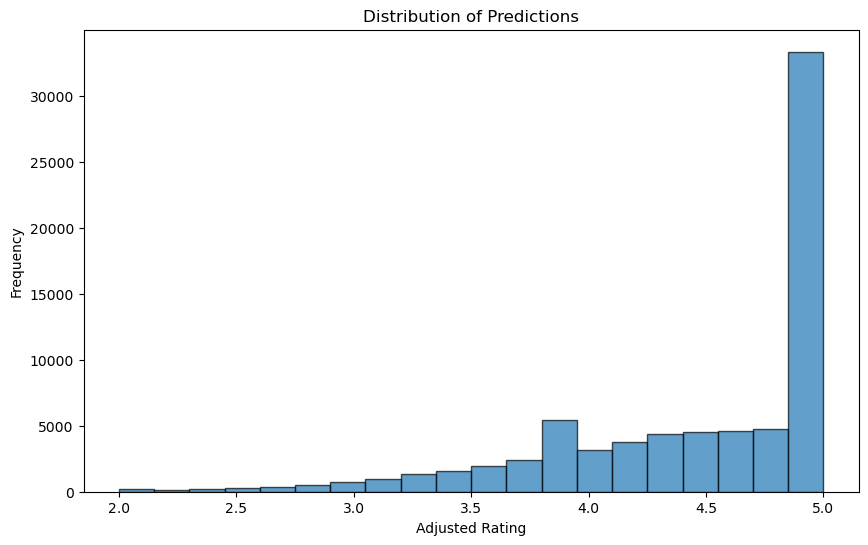

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(est_ratings, bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()

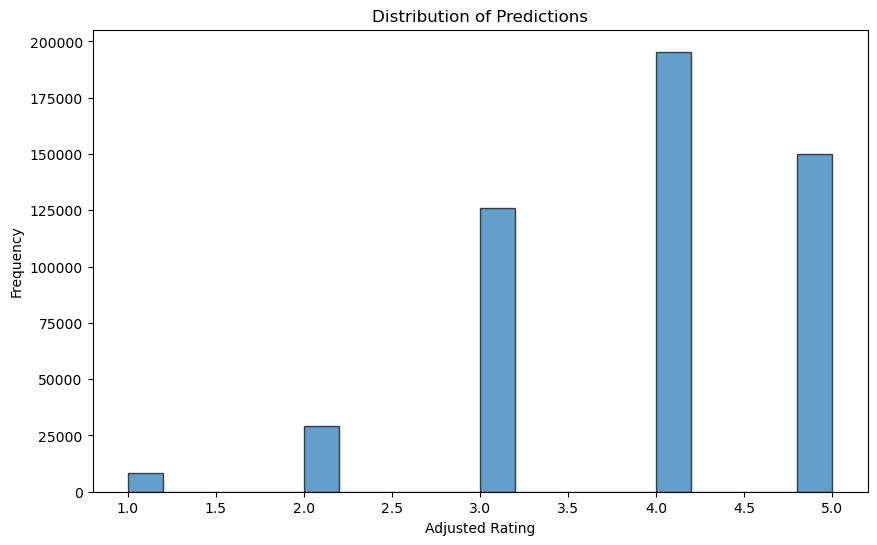

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(interactions['rating'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Predictions')
plt.xlabel('Adjusted Rating')
plt.ylabel('Frequency')
plt.show()